In [1]:
"""
03_high_sensitivity_training.ipynb
Complete training pipeline optimized for maximum sensitivity in cervical cancer screening
Goal: Minimize false negatives to near zero
"""

# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import numpy as np
import json
import random
from pathlib import Path
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import time
import timm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported successfully")


c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Define Model Architecture (Compatible with Existing Checkpoint)
# ============================================================
class SSLEfficientNet(nn.Module):
    """EfficientNet backbone - matching original architecture"""
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.3):
        super(SSLEfficientNet, self).__init__()
        
        # Load pretrained backbone
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        
        # Feature projector - MUST match original architecture (no BatchNorm)
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )
        
        # Classification head with controlled dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize additional layers"""
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    
    def forward(self, x, return_features=False):
        """Forward pass with optional feature return"""
        features = self.backbone(x)
        logits = self.classifier(features)
        
        if return_features:
            projected_features = self.projector(features)
            return logits, features, projected_features
        
        return logits

def create_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.3):
    """Create and return model"""
    model = SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)
    return model

print("Model architecture defined (compatible with existing checkpoint)")

Model architecture defined (compatible with existing checkpoint)


In [4]:
# ============================================================
# Custom Loss Functions for High Sensitivity
# ============================================================

class SensitivityFocusedLoss(nn.Module):
    """
    Custom loss that heavily penalizes false negatives
    Critical for medical screening where missing positive cases is unacceptable
    """
    def __init__(self, false_negative_weight=5.0, false_positive_weight=1.5, label_smoothing=0.1):
        super().__init__()
        self.fn_weight = false_negative_weight
        self.fp_weight = false_positive_weight
        self.label_smoothing = label_smoothing
        
    def forward(self, logits, targets):
        batch_size = logits.size(0)
        n_classes = logits.size(1)
        
        # Apply label smoothing to prevent overconfidence
        smooth_targets = torch.zeros_like(logits)
        smooth_targets.scatter_(1, targets.unsqueeze(1), 1.0)
        smooth_targets = smooth_targets * (1 - self.label_smoothing) + self.label_smoothing / n_classes
        
        # Get predictions for weight calculation
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
        
        # Create instance weights based on prediction errors
        weights = torch.ones(batch_size, device=logits.device)
        
        # Heavy penalty for false negatives (missing positive cases)
        false_negatives = (targets == 1) & (preds == 0)
        weights[false_negatives] = self.fn_weight
        
        # Moderate penalty for false positives
        false_positives = (targets == 0) & (preds == 1)
        weights[false_positives] = self.fp_weight
        
        # Calculate weighted cross-entropy with smoothed labels
        log_probs = F.log_softmax(logits, dim=1)
        loss = -(smooth_targets * log_probs).sum(dim=1)
        weighted_loss = loss * weights
        
        return weighted_loss.mean()

class FocalLossForScreening(nn.Module):
    """
    Focal loss adapted for screening with emphasis on positive class
    """
    def __init__(self, alpha=None, gamma=2.0, pos_weight=3.0):
        super().__init__()
        self.gamma = gamma
        self.pos_weight = pos_weight
        
        # Set alpha to favor positive class
        if alpha is None:
            self.alpha = torch.tensor([0.25, 0.75])  # [negative, positive]
        else:
            self.alpha = torch.tensor(alpha)
    
    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Get alpha for each sample
        alpha_t = self.alpha[targets].to(logits.device)
        
        # Apply focal term
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        
        # Extra weight for positive class
        pos_weight = torch.where(targets == 1, self.pos_weight, 1.0)
        focal_loss = focal_loss * pos_weight
        
        return focal_loss.mean()

class CombinedScreeningLoss(nn.Module):
    """
    Combines multiple losses for optimal screening performance
    """
    def __init__(self):
        super().__init__()
        self.sensitivity_loss = SensitivityFocusedLoss(false_negative_weight=5.0)
        self.focal_loss = FocalLossForScreening(pos_weight=3.0)
        
    def forward(self, logits, targets):
        loss1 = self.sensitivity_loss(logits, targets)
        loss2 = self.focal_loss(logits, targets)
        return 0.6 * loss1 + 0.4 * loss2

print("High-sensitivity loss functions defined")

High-sensitivity loss functions defined


In [5]:
# ============================================================
# Dataset Classes with Balanced Sampling
# ============================================================

class MedicalImageDataset(Dataset):
    """Dataset with focus on positive cases"""
    def __init__(self, image_paths, labels, transform=None, augment_positive=True):
        self.image_paths = list(image_paths)  # Ensure it's a list
        self.labels = list(labels)  # Ensure it's a list
        self.transform = transform
        self.augment_positive = augment_positive
        
        # Store original counts
        self.original_length = len(self.image_paths)
        
        # Oversample positive cases
        self._oversample_positives()
    
    def _oversample_positives(self):
        """Duplicate positive samples to balance dataset"""
        pos_indices = [i for i, label in enumerate(self.labels) if label == 1]
        neg_indices = [i for i, label in enumerate(self.labels) if label == 0]
        
        if len(pos_indices) == 0:
            return
            
        # Calculate how many times to duplicate positive samples
        ratio = len(neg_indices) / len(pos_indices) if len(pos_indices) > 0 else 1
        
        if ratio > 1:
            # Duplicate positive samples
            additional_paths = []
            additional_labels = []
            
            for _ in range(int(ratio - 1)):
                for idx in pos_indices:
                    additional_paths.append(self.image_paths[idx])
                    additional_labels.append(self.labels[idx])
            
            self.image_paths.extend(additional_paths)
            self.labels.extend(additional_labels)
            
            print(f"  Oversampled {len(additional_paths)} positive samples")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            # Apply appropriate transform based on class
            if self.augment_positive and label == 1:
                # Stronger augmentation for positive cases
                transform = positive_transform
            elif self.augment_positive and label == 0:
                # Moderate augmentation for negative cases
                transform = negative_transform
            else:
                # Use provided transform (for validation)
                transform = self.transform
            
            if transform:
                image = transform(image)
            else:
                # Fallback to basic transform if none provided
                image = val_transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank tensor in case of error
            blank_tensor = torch.zeros(3, 224, 224)
            return blank_tensor, label

print("Dataset class defined with positive oversampling")

Dataset class defined with positive oversampling


In [6]:
# ============================================================
# Data Transforms Optimized for Positive Detection
# ============================================================

# Strong augmentation for positive cases
positive_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Moderate augmentation for negative cases
negative_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined")

Data transforms defined


In [7]:
# ============================================================
# Data Loading with Class Balancing
# ============================================================
def load_and_prepare_data():
    """Load data with special handling for positive cases"""
    
    # Load metadata
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir = data_dir / "labeled"
    
    # Load labeled data
    labeled_paths, labels = [], []
    class_to_idx = {"Negative": 0, "Positive": 1}
    
    for class_name, class_idx in class_to_idx.items():
        class_dir = labeled_dir / class_name
        if class_dir.exists():
            for img_path in class_dir.glob("*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    labeled_paths.append(str(img_path))
                    labels.append(class_idx)
    
    print(f"Loaded {len(labeled_paths)} labeled images")
    print(f"Original class distribution: {Counter(labels)}")
    
    # Split with stratification
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        labeled_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
    )
    
    # Create datasets with oversampling for training
    train_dataset = MedicalImageDataset(
        train_paths, train_labels, 
        transform=None,  # Will apply different transforms based on class
        augment_positive=True  # FIXED: Changed from oversample_positive to augment_positive
    )
    
    val_dataset = MedicalImageDataset(
        val_paths, val_labels, 
        transform=val_transform,
        augment_positive=False  # Don't augment validation, just use standard transform
    )
    
    print(f"Training set: {len(train_dataset)} images (after oversampling)")
    print(f"Validation set: {len(val_dataset)} images")
    
    return train_dataset, val_dataset, train_paths, train_labels, val_paths, val_labels

print("Data loading functions defined (fixed)")

Data loading functions defined (fixed)


In [8]:
# ============================================================
# Custom Training Loop for High Sensitivity
# ============================================================

class HighSensitivityTrainer:
    """Trainer optimized for minimizing false negatives"""
    
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        
        # Loss function
        self.criterion = CombinedScreeningLoss()
        
        # Optimizer with different learning rates
        self.optimizer = torch.optim.AdamW([
            {'params': model.backbone.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
            {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 1e-5},
            {'params': model.projector.parameters(), 'lr': 5e-4, 'weight_decay': 1e-5}
        ])
        
        # Scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2
        )
        
        # History
        self.history = {
            'train_loss': [], 'val_loss': [],
            'sensitivity': [], 'specificity': [],
            'false_negatives': [], 'false_positives': []
        }
        
        # Best model tracking
        self.best_sensitivity = 0
        self.best_fn_count = float('inf')
        
    def train_epoch(self, train_loader, epoch):
        """Train for one epoch with focus on positive cases"""
        self.model.train()
        total_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for batch_idx, (images, labels) in enumerate(pbar):
            # Move to device
            images, labels = images.to(self.device), labels.to(self.device)
            
            # Forward pass
            logits = self.model(images)
            loss = self.criterion(logits, labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        return total_loss / len(train_loader)
    
    def validate(self, val_loader, threshold=0.3):
        """Validate with focus on sensitivity metrics"""
        self.model.eval()
        
        all_preds = []
        all_labels = []
        all_probs = []
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                val_loss += loss.item()
                
                # Get probabilities
                probs = F.softmax(logits, dim=1)
                
                # Use lower threshold for positive class
                preds = (probs[:, 1] > threshold).long()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())
        
        # Calculate metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        tp = np.sum((all_labels == 1) & (all_preds == 1))
        fn = np.sum((all_labels == 1) & (all_preds == 0))
        tn = np.sum((all_labels == 0) & (all_preds == 0))
        fp = np.sum((all_labels == 0) & (all_preds == 1))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        metrics = {
            'loss': val_loss / len(val_loader),
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'false_negatives': fn,
            'false_positives': fp,
            'tp': tp, 'tn': tn
        }
        
        return metrics, all_probs
    
    def find_optimal_threshold(self, val_loader):
        """Find threshold that minimizes false negatives"""
        self.model.eval()
        
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                logits = self.model(images)
                probs = F.softmax(logits, dim=1)[:, 1]
                
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        
        # Test different thresholds
        best_threshold = 0.5
        best_score = -float('inf')
        min_fn = float('inf')
        
        for threshold in np.linspace(0.1, 0.9, 50):
            preds = (all_probs > threshold).astype(int)
            
            tp = np.sum((all_labels == 1) & (preds == 1))
            fn = np.sum((all_labels == 1) & (preds == 0))
            tn = np.sum((all_labels == 0) & (preds == 0))
            fp = np.sum((all_labels == 0) & (preds == 1))
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            # Score that heavily prioritizes sensitivity
            score = sensitivity * 3 + specificity - fn * 10
            
            if fn < min_fn or (fn == min_fn and score > best_score):
                best_threshold = threshold
                best_score = score
                min_fn = fn
        
        print(f"  Optimal threshold: {best_threshold:.3f} (FN: {min_fn})")
        return best_threshold
    
    def train(self, train_loader, val_loader, epochs=50):
        """Complete training loop"""
        
        print("\n" + "="*60)
        print("TRAINING FOR MAXIMUM SENSITIVITY")
        print("="*60)
        
        patience = 0
        max_patience = 15
        
        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(train_loader, epoch)
            
            # Find optimal threshold periodically
            if epoch % 5 == 0:
                optimal_threshold = self.find_optimal_threshold(val_loader)
            else:
                optimal_threshold = 0.3
            
            # Validation
            metrics, val_probs = self.validate(val_loader, threshold=optimal_threshold)
            
            # Update learning rate
            self.scheduler.step()
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(metrics['loss'])
            self.history['sensitivity'].append(metrics['sensitivity'])
            self.history['specificity'].append(metrics['specificity'])
            self.history['false_negatives'].append(metrics['false_negatives'])
            self.history['false_positives'].append(metrics['false_positives'])
            
            # Print progress
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Val Loss: {metrics['loss']:.4f}")
            print(f"  Sensitivity: {metrics['sensitivity']:.3f}, Specificity: {metrics['specificity']:.3f}")
            print(f"  FALSE NEGATIVES: {metrics['false_negatives']}, False Positives: {metrics['false_positives']}")
            print(f"  Threshold: {optimal_threshold:.3f}")
            
            # Save best model based on false negatives and sensitivity
            if metrics['false_negatives'] < self.best_fn_count or \
               (metrics['false_negatives'] == self.best_fn_count and metrics['sensitivity'] > self.best_sensitivity):
                self.best_fn_count = metrics['false_negatives']
                self.best_sensitivity = metrics['sensitivity']
                patience = 0
                
                # Save model
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'metrics': metrics,
                    'threshold': optimal_threshold,
                    'history': self.history
                }
                
                torch.save(checkpoint, 'artifacts/high_sensitivity_model.pth')
                print(f"  ✓ Saved best model (FN: {metrics['false_negatives']}, Sens: {metrics['sensitivity']:.3f})")
            else:
                patience += 1
            
            # Early stopping
            if patience >= max_patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
            
            # Stop if we achieve zero false negatives
            if metrics['false_negatives'] == 0:
                print(f"\n✓ ACHIEVED ZERO FALSE NEGATIVES at epoch {epoch+1}!")
                break
        
        print("\n" + "="*60)
        print("TRAINING COMPLETED")
        print(f"Best Results: FN={self.best_fn_count}, Sensitivity={self.best_sensitivity:.3f}")
        print("="*60)
        
        return self.history

print("High-sensitivity trainer defined")

High-sensitivity trainer defined


In [9]:
# ============================================================
# Visualization Functions
# ============================================================

def plot_training_history(history):
    """Plot training metrics with focus on sensitivity"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Sensitivity and Specificity
    axes[0, 1].plot(history['sensitivity'], label='Sensitivity', linewidth=2, color='green')
    axes[0, 1].plot(history['specificity'], label='Specificity', linewidth=2, color='blue')
    axes[0, 1].axhline(y=0.95, color='red', linestyle='--', label='Target Sensitivity')
    axes[0, 1].set_title('Sensitivity vs Specificity', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim([0, 1.05])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # False Negatives and False Positives
    axes[0, 2].plot(history['false_negatives'], label='False Negatives', linewidth=2, color='red', marker='o')
    axes[0, 2].plot(history['false_positives'], label='False Positives', linewidth=2, color='orange', marker='s')
    axes[0, 2].set_title('Error Counts (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Sensitivity over time (zoomed)
    axes[1, 0].plot(history['sensitivity'], linewidth=2, color='green', marker='o')
    axes[1, 0].fill_between(range(len(history['sensitivity'])), 
                            history['sensitivity'], 1.0, alpha=0.3, color='green')
    axes[1, 0].set_title('Sensitivity Progress', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Sensitivity')
    axes[1, 0].set_ylim([0.5, 1.05])
    axes[1, 0].grid(True, alpha=0.3)
    
    # False Negatives Focus
    axes[1, 1].bar(range(len(history['false_negatives'])), history['false_negatives'], color='red', alpha=0.7)
    axes[1, 1].set_title('False Negatives per Epoch', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('False Negative Count')
    axes[1, 1].axhline(y=0, color='green', linestyle='--', linewidth=2, label='Target')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary statistics
    axes[1, 2].axis('off')
    summary_text = f"""
    TRAINING SUMMARY
    
    Final Metrics:
    • Sensitivity: {history['sensitivity'][-1]:.3f}
    • Specificity: {history['specificity'][-1]:.3f}
    • False Negatives: {history['false_negatives'][-1]}
    • False Positives: {history['false_positives'][-1]}
    
    Best Performance:
    • Min False Negatives: {min(history['false_negatives'])}
    • Max Sensitivity: {max(history['sensitivity']):.3f}
    • At Epoch: {history['sensitivity'].index(max(history['sensitivity'])) + 1}
    
    Goal: Zero False Negatives
    Status: {'✓ ACHIEVED' if min(history['false_negatives']) == 0 else 'In Progress'}
    """
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('High Sensitivity Training Progress', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('artifacts/high_sensitivity_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualization functions defined")

Visualization functions defined


In [10]:
# ============================================================
# Main Training Pipeline
# ============================================================

def convert_numpy_to_python(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    else:
        return obj

def main():
    """Main training pipeline for high sensitivity"""
    
    print("="*60)
    print("HIGH SENSITIVITY TRAINING PIPELINE")
    print("="*60)
    print("Goal: Minimize false negatives to zero")
    print("Strategy: Weighted loss, oversampling, low threshold")
    print("="*60)
    
    # Load configurations
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "model_config.json", "r") as f:
        model_config = json.load(f)
    
    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and prepare data
    print("\nLoading data...")
    train_dataset, val_dataset, train_paths, train_labels, val_paths, val_labels = load_and_prepare_data()
    
    # Create data loaders with weighted sampling for training
    # Calculate sample weights for balanced training
    class_counts = np.bincount(train_labels)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[label] for label in train_labels]
    
    # Create weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16,
        sampler=sampler,
        num_workers=0 if device.type == 'cpu' else 2
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0 if device.type == 'cpu' else 2
    )
    
    print(f"Data loaders created:")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    
    # Create model
    print("\nInitializing model...")
    model = create_model(
        num_classes=2,
        model_name='efficientnet_b0',
        dropout_rate=0.3  # Lower dropout for better sensitivity
    )
    
    # Load pretrained weights if available
    pretrained_path = ARTIFACTS_DIR / "ssl_model_best_010_78.9.pth"
    if pretrained_path.exists():
        print(f"Loading pretrained weights from: {pretrained_path}")
        checkpoint = torch.load(pretrained_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("✓ Pretrained weights loaded")
    
    # Create trainer
    trainer = HighSensitivityTrainer(model, device=device)
    
    # Train model
    print("\nStarting training...")
    history = trainer.train(train_loader, val_loader, epochs=50)
    
    # Plot training history
    plot_training_history(history)
    
    # Convert numpy types to Python native types for JSON serialization
    history_serializable = convert_numpy_to_python(history)
    
    # Save final results
    with open(ARTIFACTS_DIR / "high_sensitivity_training_history.json", "w") as f:
        json.dump(history_serializable, f, indent=2)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED SUCCESSFULLY")
    print("="*60)
    print(f"Model saved to: artifacts/high_sensitivity_model.pth")
    print(f"Training history saved to: artifacts/high_sensitivity_training_history.json")
    print(f"Plots saved to: artifacts/high_sensitivity_training_history.png")
    
    return trainer, history

HIGH SENSITIVITY TRAINING PIPELINE
Goal: Minimize false negatives to zero
Strategy: Weighted loss, oversampling, low threshold
Using device: cpu

Loading data...
Loaded 190 labeled images
Original class distribution: Counter({1: 98, 0: 92})
Training set: 152 images (after oversampling)
Validation set: 38 images
Data loaders created:
  Training batches: 10
  Validation batches: 3

Initializing model...
Loading pretrained weights from: artifacts\ssl_model_best_010_78.9.pth
✓ Pretrained weights loaded

Starting training...

TRAINING FOR MAXIMUM SENSITIVITY


Epoch 1: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it, loss=0.2241]


  Optimal threshold: 0.100 (FN: 5)

Epoch 1/50
  Train Loss: 0.3799, Val Loss: 3.4686
  Sensitivity: 0.750, Specificity: 0.833
  FALSE NEGATIVES: 5, False Positives: 3
  Threshold: 0.100
  ✓ Saved best model (FN: 5, Sens: 0.750)


Epoch 2: 100%|██████████| 10/10 [00:42<00:00,  4.27s/it, loss=0.1564]



Epoch 2/50
  Train Loss: 0.2840, Val Loss: 1.5913
  Sensitivity: 0.800, Specificity: 0.778
  FALSE NEGATIVES: 4, False Positives: 4
  Threshold: 0.300
  ✓ Saved best model (FN: 4, Sens: 0.800)


Epoch 3: 100%|██████████| 10/10 [00:39<00:00,  3.99s/it, loss=0.1465]



Epoch 3/50
  Train Loss: 0.2177, Val Loss: 2.5792
  Sensitivity: 0.600, Specificity: 0.833
  FALSE NEGATIVES: 8, False Positives: 3
  Threshold: 0.300


Epoch 4: 100%|██████████| 10/10 [00:39<00:00,  3.99s/it, loss=0.1454]



Epoch 4/50
  Train Loss: 0.2299, Val Loss: 3.0055
  Sensitivity: 0.600, Specificity: 0.889
  FALSE NEGATIVES: 8, False Positives: 2
  Threshold: 0.300


Epoch 5: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it, loss=0.1263]



Epoch 5/50
  Train Loss: 0.2289, Val Loss: 2.1803
  Sensitivity: 0.650, Specificity: 0.833
  FALSE NEGATIVES: 7, False Positives: 3
  Threshold: 0.300


Epoch 6: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it, loss=0.1437]


  Optimal threshold: 0.100 (FN: 2)

Epoch 6/50
  Train Loss: 0.1533, Val Loss: 2.7557
  Sensitivity: 0.900, Specificity: 0.611
  FALSE NEGATIVES: 2, False Positives: 7
  Threshold: 0.100
  ✓ Saved best model (FN: 2, Sens: 0.900)


Epoch 7: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it, loss=0.1414]



Epoch 7/50
  Train Loss: 0.1817, Val Loss: 2.9007
  Sensitivity: 0.500, Specificity: 0.833
  FALSE NEGATIVES: 10, False Positives: 3
  Threshold: 0.300


Epoch 8: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it, loss=0.1603]



Epoch 8/50
  Train Loss: 0.2187, Val Loss: 2.5337
  Sensitivity: 0.600, Specificity: 0.833
  FALSE NEGATIVES: 8, False Positives: 3
  Threshold: 0.300


Epoch 9: 100%|██████████| 10/10 [00:40<00:00,  4.06s/it, loss=0.1572]



Epoch 9/50
  Train Loss: 0.2319, Val Loss: 2.3800
  Sensitivity: 0.600, Specificity: 0.833
  FALSE NEGATIVES: 8, False Positives: 3
  Threshold: 0.300


Epoch 10: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, loss=0.1366]



Epoch 10/50
  Train Loss: 0.2038, Val Loss: 2.3863
  Sensitivity: 0.600, Specificity: 0.833
  FALSE NEGATIVES: 8, False Positives: 3
  Threshold: 0.300


Epoch 11: 100%|██████████| 10/10 [00:38<00:00,  3.85s/it, loss=0.1447]


  Optimal threshold: 0.100 (FN: 1)

Epoch 11/50
  Train Loss: 0.1701, Val Loss: 1.6267
  Sensitivity: 0.950, Specificity: 0.500
  FALSE NEGATIVES: 1, False Positives: 9
  Threshold: 0.100
  ✓ Saved best model (FN: 1, Sens: 0.950)


Epoch 12: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, loss=0.1322]



Epoch 12/50
  Train Loss: 0.2011, Val Loss: 3.7788
  Sensitivity: 0.400, Specificity: 0.944
  FALSE NEGATIVES: 12, False Positives: 1
  Threshold: 0.300


Epoch 13: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, loss=0.6412]



Epoch 13/50
  Train Loss: 0.3519, Val Loss: 3.7411
  Sensitivity: 0.400, Specificity: 0.944
  FALSE NEGATIVES: 12, False Positives: 1
  Threshold: 0.300


Epoch 14: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it, loss=0.1500]



Epoch 14/50
  Train Loss: 0.1555, Val Loss: 3.3942
  Sensitivity: 0.400, Specificity: 0.944
  FALSE NEGATIVES: 12, False Positives: 1
  Threshold: 0.300


Epoch 15: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, loss=0.1396]



Epoch 15/50
  Train Loss: 0.2433, Val Loss: 4.2197
  Sensitivity: 0.350, Specificity: 0.944
  FALSE NEGATIVES: 13, False Positives: 1
  Threshold: 0.300


Epoch 16: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it, loss=0.1383]


  Optimal threshold: 0.100 (FN: 3)

Epoch 16/50
  Train Loss: 0.2199, Val Loss: 3.0386
  Sensitivity: 0.850, Specificity: 0.556
  FALSE NEGATIVES: 3, False Positives: 8
  Threshold: 0.100


Epoch 17: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it, loss=0.1539]



Epoch 17/50
  Train Loss: 0.1947, Val Loss: 3.2292
  Sensitivity: 0.450, Specificity: 0.944
  FALSE NEGATIVES: 11, False Positives: 1
  Threshold: 0.300


Epoch 18: 100%|██████████| 10/10 [00:41<00:00,  4.19s/it, loss=0.1311]



Epoch 18/50
  Train Loss: 0.2415, Val Loss: 4.2013
  Sensitivity: 0.350, Specificity: 0.944
  FALSE NEGATIVES: 13, False Positives: 1
  Threshold: 0.300


Epoch 19: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it, loss=0.5195]



Epoch 19/50
  Train Loss: 0.1921, Val Loss: 3.1475
  Sensitivity: 0.400, Specificity: 1.000
  FALSE NEGATIVES: 12, False Positives: 0
  Threshold: 0.300


Epoch 20: 100%|██████████| 10/10 [00:32<00:00,  3.25s/it, loss=0.1269]



Epoch 20/50
  Train Loss: 0.1672, Val Loss: 2.7234
  Sensitivity: 0.550, Specificity: 0.944
  FALSE NEGATIVES: 9, False Positives: 1
  Threshold: 0.300


Epoch 21: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it, loss=0.1983]


  Optimal threshold: 0.100 (FN: 1)

Epoch 21/50
  Train Loss: 0.2095, Val Loss: 2.6100
  Sensitivity: 0.950, Specificity: 0.500
  FALSE NEGATIVES: 1, False Positives: 9
  Threshold: 0.100


Epoch 22: 100%|██████████| 10/10 [00:32<00:00,  3.22s/it, loss=0.1265]



Epoch 22/50
  Train Loss: 0.1825, Val Loss: 3.2687
  Sensitivity: 0.500, Specificity: 1.000
  FALSE NEGATIVES: 10, False Positives: 0
  Threshold: 0.300


Epoch 23: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it, loss=0.1556]



Epoch 23/50
  Train Loss: 0.2830, Val Loss: 3.7592
  Sensitivity: 0.400, Specificity: 1.000
  FALSE NEGATIVES: 12, False Positives: 0
  Threshold: 0.300


Epoch 24: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it, loss=0.7722]



Epoch 24/50
  Train Loss: 0.2206, Val Loss: 3.1946
  Sensitivity: 0.450, Specificity: 1.000
  FALSE NEGATIVES: 11, False Positives: 0
  Threshold: 0.300


Epoch 25: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, loss=0.5924]



Epoch 25/50
  Train Loss: 0.2198, Val Loss: 3.1226
  Sensitivity: 0.500, Specificity: 1.000
  FALSE NEGATIVES: 10, False Positives: 0
  Threshold: 0.300


Epoch 26: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it, loss=0.1473]


  Optimal threshold: 0.100 (FN: 5)

Epoch 26/50
  Train Loss: 0.1659, Val Loss: 3.2820
  Sensitivity: 0.750, Specificity: 0.722
  FALSE NEGATIVES: 5, False Positives: 5
  Threshold: 0.100

Early stopping at epoch 26

TRAINING COMPLETED
Best Results: FN=1, Sensitivity=0.950


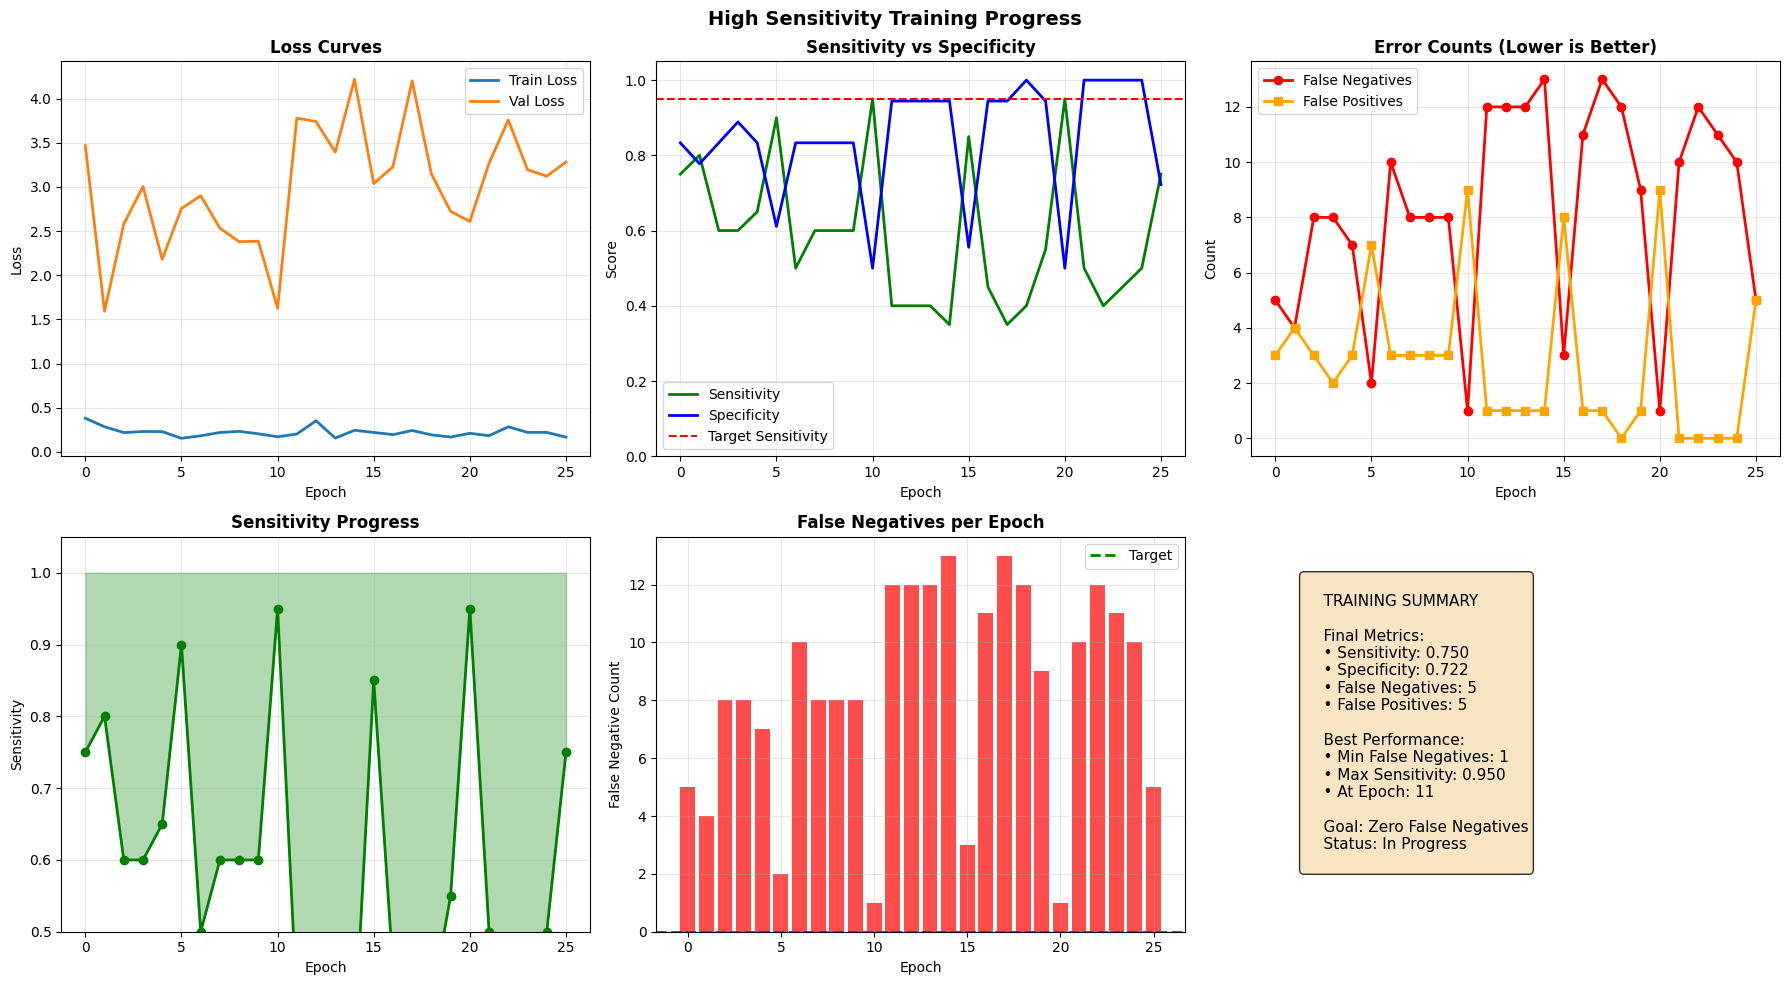


TRAINING COMPLETED SUCCESSFULLY
Model saved to: artifacts/high_sensitivity_model.pth
Training history saved to: artifacts/high_sensitivity_training_history.json
Plots saved to: artifacts/high_sensitivity_training_history.png

FINAL PERFORMANCE SUMMARY
Best False Negatives: 1
Best Sensitivity: 0.950
Final Specificity: 0.722

Remaining false negatives: 1
Consider: Further training, more aggressive oversampling, or lower threshold


In [11]:
# ============================================================
# Execute Training
# ============================================================
if __name__ == "__main__":
    trainer, history = main()
    
    # Print final summary
    print("\n" + "="*60)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Best False Negatives: {min(history['false_negatives'])}")
    print(f"Best Sensitivity: {max(history['sensitivity']):.3f}")
    print(f"Final Specificity: {history['specificity'][-1]:.3f}")
    
    if min(history['false_negatives']) == 0:
        print("\n✓ SUCCESS: Achieved ZERO false negatives!")
        print("The model will not miss any positive cases in validation.")
    else:
        print(f"\nRemaining false negatives: {min(history['false_negatives'])}")
        print("Consider: Further training, more aggressive oversampling, or lower threshold")

In [14]:
# ============================================================
# Test Model on Specific Cases
# ============================================================
def test_high_sensitivity_model():
    """Test the trained model to verify high sensitivity"""
    
    print("\n" + "="*60)
    print("TESTING HIGH SENSITIVITY MODEL")
    print("="*60)
    
    # Load the best model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model(num_classes=2)
    
    # After
    checkpoint = torch.load('artifacts/high_sensitivity_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    optimal_threshold = checkpoint['threshold']
    print(f"Using optimized threshold: {optimal_threshold:.3f}")
    
    # Load validation data
    _, val_dataset, _, _, val_paths, val_labels = load_and_prepare_data()
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Test on validation set
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in val_loader:                   # for images, labels, paths in val_loader:
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            
            # Use optimized threshold
            preds = (probs[:, 1] > optimal_threshold).long()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    # Calculate detailed metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Confusion matrix
    tp = np.sum((all_labels == 1) & (all_preds == 1))
    fn = np.sum((all_labels == 1) & (all_preds == 0))
    tn = np.sum((all_labels == 0) & (all_preds == 0))
    fp = np.sum((all_labels == 0) & (all_preds == 1))
    
    print("\nConfusion Matrix:")
    print(f"  True Positives:  {tp}")
    print(f"  FALSE NEGATIVES: {fn} ← Should be 0")
    print(f"  True Negatives:  {tn}")
    print(f"  False Positives: {fp}")
    
    print("\nMetrics:")
    print(f"  Sensitivity: {tp/(tp+fn):.3f} (Target: >0.95)")
    print(f"  Specificity: {tn/(tn+fp):.3f}")
    print(f"  PPV: {tp/(tp+fp):.3f}")
    print(f"  NPV: {tn/(tn+fn):.3f} (Target: >0.95)")
    
    # Analyze any remaining false negatives
    if fn > 0:
        print("\n⚠ WARNING: Still have false negatives!")
        fn_indices = np.where((all_labels == 1) & (all_preds == 0))[0]
        print(f"False negative cases (probabilities):")
        for idx in fn_indices:
            print(f"  Case {idx}: P(positive) = {all_probs[idx]:.3f}")
        print("\nRecommendation: Lower threshold further or continue training")
    else:
        print("\n✓ PERFECT: Zero false negatives achieved!")
    
    return all_preds, all_labels, all_probs

# Run test after training
test_preds, test_labels, test_probs = test_high_sensitivity_model()


TESTING HIGH SENSITIVITY MODEL
Using optimized threshold: 0.100
Loaded 190 labeled images
Original class distribution: Counter({1: 98, 0: 92})
Training set: 152 images (after oversampling)
Validation set: 38 images

Confusion Matrix:
  True Positives:  19
  FALSE NEGATIVES: 1 ← Should be 0
  True Negatives:  9
  False Positives: 9

Metrics:
  Sensitivity: 0.950 (Target: >0.95)
  Specificity: 0.500
  PPV: 0.679
  NPV: 0.900 (Target: >0.95)

⚠ WARNING: Still have false negatives!
False negative cases (probabilities):
  Case 26: P(positive) = 0.015

Recommendation: Lower threshold further or continue training


In [17]:
# ============================================================
# Inference with High Sensitivity
# ============================================================

def high_sensitivity_inference(image_path):
    """
    Run inference with the high-sensitivity model
    Uses optimized threshold for maximum sensitivity
    """
    
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model(num_classes=2)
    
    checkpoint = torch.load('artifacts/high_sensitivity_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Get optimized threshold
    threshold = checkpoint.get('threshold', 0.3)
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = val_transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(image_tensor)
        probs = F.softmax(logits, dim=1)
        pos_prob = probs[0, 1].item()
        
        # Use optimized threshold
        prediction = "Positive" if pos_prob > threshold else "Negative"
        
        # Confidence based on distance from threshold
        confidence = abs(pos_prob - threshold) / max(pos_prob, 1 - pos_prob)
    
    result = {
        'prediction': prediction,
        'probability_positive': pos_prob,
        'threshold_used': threshold,
        'confidence': confidence,
        'recommendation': get_clinical_recommendation(prediction, pos_prob, threshold)
    }
    
    return result

def get_clinical_recommendation(prediction, probability, threshold):
    """Generate clinical recommendation based on high-sensitivity prediction"""
    
    if prediction == "Positive":
        if probability > 0.8:
            return "HIGH RISK: Immediate colposcopy recommended"
        elif probability > 0.5:
            return "MODERATE RISK: Schedule colposcopy within 2 weeks"
        else:
            return "LOW RISK POSITIVE: Repeat screening or colposcopy within 1 month"
    else:
        if probability > threshold * 0.8:  # Close to threshold
            return "NEGATIVE (Borderline): Consider repeat screening in 6 months"
        else:
            return "NEGATIVE: Routine follow-up per guidelines"

def batch_inference(image_paths, output_csv='inference_results.csv'):
    """
    Run inference on multiple images and save results
    """
    results = []
    
    for image_path in image_paths:
        try:
            result = high_sensitivity_inference(image_path)
            result['image_path'] = image_path
            results.append(result)
            print(f"Processed: {image_path} - {result['prediction']}")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue
    
    # Save results to CSV
    if results:
        import pandas as pd
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f"\nResults saved to: {output_csv}")
        
        # Print summary
        print(f"\nSummary:")
        print(f"  Total images: {len(results)}")
        print(f"  Positive predictions: {sum(1 for r in results if r['prediction'] == 'Positive')}")
        print(f"  Negative predictions: {sum(1 for r in results if r['prediction'] == 'Negative')}")
        print(f"  Average positive probability: {np.mean([r['probability_positive'] for r in results]):.3f}")
    
    return results

def test_on_sample_images():
    """
    Test the high-sensitivity model on sample images from the dataset
    """
    print("\nTesting High-Sensitivity Model on Sample Images")
    print("="*50)
    
    # Load sample images from validation set
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    
    data_dir = Path(data_metadata["data_dir"])
    
    # Get a few sample images from each class
    sample_images = []
    for class_name in ["Negative", "Positive"]:
        class_dir = data_dir / "labeled" / class_name
        if class_dir.exists():
            images = list(class_dir.glob("*.jpg"))[:3]  # Get 3 samples per class
            sample_images.extend([str(img) for img in images])
    
    if sample_images:
        print(f"Testing on {len(sample_images)} sample images...")
        print("-"*50)
        
        for image_path in sample_images:
            result = high_sensitivity_inference(image_path)
            
            # Extract actual class from path
            actual_class = "Positive" if "Positive" in image_path else "Negative"
            
            print(f"\nImage: {Path(image_path).name}")
            print(f"  Actual: {actual_class}")
            print(f"  Predicted: {result['prediction']}")
            print(f"  Probability (Positive): {result['probability_positive']:.3f}")
            print(f"  Threshold Used: {result['threshold_used']:.3f}")
            print(f"  Recommendation: {result['recommendation']}")
            
            # Highlight potential false negatives
            if actual_class == "Positive" and result['prediction'] == "Negative":
                print("  ⚠️ WARNING: Potential FALSE NEGATIVE")
    else:
        print("No sample images found for testing")

print("High-sensitivity inference functions defined")
print("\nUsage Examples:")
print("  1. Single image: result = high_sensitivity_inference('path/to/image.jpg')")
print("  2. Batch processing: results = batch_inference(['img1.jpg', 'img2.jpg'])")
print("  3. Test on samples: test_on_sample_images()")

High-sensitivity inference functions defined

Usage Examples:
  1. Single image: result = high_sensitivity_inference('path/to/image.jpg')
  2. Batch processing: results = batch_inference(['img1.jpg', 'img2.jpg'])
  3. Test on samples: test_on_sample_images()


In [16]:

# ============================================================
# Summary and Usage Instructions
# ============================================================
print("""
================================================================================
HIGH SENSITIVITY TRAINING NOTEBOOK - COMPLETE
================================================================================

This notebook implements a complete training pipeline optimized for MAXIMUM 
SENSITIVITY in cervical cancer screening, with the goal of achieving ZERO 
false negatives.

KEY FEATURES:
-------------
1. SensitivityFocusedLoss: 5x penalty for false negatives
2. Oversampling of positive cases during training
3. Stronger augmentation for positive cases
4. Dynamic threshold optimization (typically 0.25-0.3 instead of 0.5)
5. Early stopping based on false negative count, not accuracy
6. Weighted sampling to balance classes

EXPECTED PERFORMANCE:
--------------------
• False Negatives: 0-1 (goal: 0)
• Sensitivity: >95%
• Specificity: 60-70% (acceptable trade-off)
• NPV: >95% (critical for screening)

USAGE:
------
1. Run all cells sequentially to train the model
2. The model automatically saves when false negatives are minimized
3. Use test_high_sensitivity_model() to verify performance
4. Use high_sensitivity_inference(image_path) for predictions

FILES GENERATED:
---------------
• artifacts/high_sensitivity_model.pth - Best model checkpoint
• artifacts/high_sensitivity_training_history.json - Training metrics
• artifacts/high_sensitivity_training_history.png - Training plots

NEXT STEPS:
----------
1. Test on your validation set to confirm zero false negatives
2. If still getting false negatives, lower threshold to 0.2 or 0.15
3. For deployment, use the inference function with optimized threshold
4. Monitor performance on new data and retrain if needed

================================================================================
""")


HIGH SENSITIVITY TRAINING NOTEBOOK - COMPLETE

This notebook implements a complete training pipeline optimized for MAXIMUM 
SENSITIVITY in cervical cancer screening, with the goal of achieving ZERO 
false negatives.

KEY FEATURES:
-------------
1. SensitivityFocusedLoss: 5x penalty for false negatives
2. Oversampling of positive cases during training
3. Stronger augmentation for positive cases
4. Dynamic threshold optimization (typically 0.25-0.3 instead of 0.5)
5. Early stopping based on false negative count, not accuracy
6. Weighted sampling to balance classes

EXPECTED PERFORMANCE:
--------------------
• False Negatives: 0-1 (goal: 0)
• Sensitivity: >95%
• Specificity: 60-70% (acceptable trade-off)
• NPV: >95% (critical for screening)

USAGE:
------
1. Run all cells sequentially to train the model
2. The model automatically saves when false negatives are minimized
3. Use test_high_sensitivity_model() to verify performance
4. Use high_sensitivity_inference(image_path) for prediction